# **ASHRAE Energy Prediction**

In [1]:
# Import Statements

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import statistics
import seaborn as sns
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from copy import copy
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)

In [2]:
# Code from https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction 
# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# function to calculate evaluation metric
def rmsle(y_true: pd.Series, y_predict: pd.Series) -> float:
    """
    Evaluate root mean squared log error
    :param y_true:
    :param y_predict:
    :return:
    """
    return np.sqrt(msle(y_true, y_predict))

In [3]:
# Import data
INPUT = "../input/ashrae-energy-prediction/"

df_train = pd.read_csv(f"{INPUT}train.csv")
df_test = pd.read_csv(f"{INPUT}test.csv")
bldg_metadata = pd.read_csv(f"{INPUT}building_metadata.csv")
weather_train = pd.read_csv(f"{INPUT}weather_train.csv")
weather_test = pd.read_csv(f"{INPUT}weather_test.csv")
sample = pd.read_csv(f"{INPUT}sample_submission.csv")

In [4]:
df_train.shape

(20216100, 4)

In [5]:
df_test.shape

(41697600, 4)

In [6]:
df_test = df_test.drop(columns=['row_id'])

In [7]:
df_train = reduce_mem_usage(df=df_train)
df_test = reduce_mem_usage(df=df_test)
weather_train = reduce_mem_usage(df=weather_train)
weather_test = reduce_mem_usage(df=weather_test)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 437.43 Mb (54.2% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [8]:
df_train = df_train.merge(bldg_metadata, on='building_id', how='left')
df_test = df_test.merge(bldg_metadata, on='building_id', how='left')
df_train = df_train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
df_test = df_test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [9]:
import gc
del weather_train, weather_test, bldg_metadata
gc.collect()

11

In [10]:
df_train['timestamp'] = pd.to_datetime(arg=df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(arg=df_test['timestamp'])

## Feature Engineering

In [11]:
# Extracting date features from timestamp
df_train['year'] = df_train['timestamp'].dt.year
df_train['month'] = df_train['timestamp'].dt.month
df_train['day'] = df_train['timestamp'].dt.day
df_train['hour'] = df_train['timestamp'].dt.hour
df_test['year'] = df_test['timestamp'].dt.year
df_test['month'] = df_test['timestamp'].dt.month
df_test['day'] = df_test['timestamp'].dt.day
df_test['hour'] = df_test['timestamp'].dt.hour
df_train['dayofweek'] = df_train['timestamp'].dt.dayofweek
df_test['dayofweek'] = df_test['timestamp'].dt.dayofweek

# 1: day, 2:night. Hope this save some memory
df_train['day-and-night'] = np.where((df_train['hour'] < 6), 2, 1)
df_test['day-and-night'] = np.where((df_test['hour'] < 6), 2, 1)

#1: winter, 2: spring, 3: summer, 4: autumn. Hope this save some memory 
df_train.loc[df_train['month'].isin([12, 1, 2]), 'season'] = 1
df_train.loc[df_train['month'].isin([3, 4, 5]), 'season'] = 2
df_train.loc[df_train['month'].isin([6, 7, 8]), 'season'] = 3
df_train.loc[df_train['month'].isin([9, 10, 11]), 'season'] = 4
df_test.loc[df_test['month'].isin([12, 1, 2]), 'season'] = 1
df_test.loc[df_test['month'].isin([3, 4, 5]), 'season'] = 2
df_test.loc[df_test['month'].isin([6, 7, 8]), 'season'] = 3
df_test.loc[df_test['month'].isin([9, 10, 11]), 'season'] = 4

In [12]:
# Because we made few new features we can try to reduce memory once again
df_train = reduce_mem_usage(df=df_train)
df_test = reduce_mem_usage(df=df_test)

Mem. usage decreased to 1214.61 Mb (52.6% reduction)
Mem. usage decreased to 2346.19 Mb (54.3% reduction)


In [13]:
# Making age feature
df_train['age'] = df_train['year'] - df_train['year_built']
df_test['age'] = df_test['year'] - df_test['year_built']

# Making number of hours passed from start
new_df = df_train.groupby(by=['building_id'], as_index=False)['timestamp'].min()
new_df = new_df.rename(columns = {'timestamp': 'start_ts'})

df_train = df_train.merge(new_df, on = 'building_id', how='left')
df_test = df_test.merge(new_df, on = 'building_id', how='left')

df_train['hours_passed'] = (df_train['timestamp'] - df_train['start_ts']).dt.total_seconds()/3600
df_test['hours_passed'] = (df_test['timestamp'] - df_test['start_ts']).dt.total_seconds()/3600

In [14]:
# Because we made few new features we can try to reduce memory once again
df_train = reduce_mem_usage(df=df_train)
df_test = reduce_mem_usage(df=df_test)

Mem. usage decreased to 1445.97 Mb (9.6% reduction)
Mem. usage decreased to 2823.38 Mb (10.1% reduction)


In [15]:
# Making combination of categorical variable to see if they help model become better
# df_train['building_id_meter_hours_passed'] = df_train['building_id'].astype(str) + '_' + df_train['meter'].astype(str) + '_' + df_train['hours_passed'].astype(str)
# df_test['building_id_meter_hours_passed'] = df_test['building_id'].astype(str) + '_' + df_test['meter'].astype(str) + '_' + df_test['hours_passed'].astype(str)

# # Because we made few new features we can try to reduce memory once again
# df_train = reduce_mem_usage(df=df_train)
# df_test = reduce_mem_usage(df=df_test)

# df_train['building_id_meter'] = df_train['building_id'].astype(str) + '_' + df_train['meter'].astype(str)
# df_test['building_id_meter'] = df_test['building_id'].astype(str) + '_' + df_test['meter'].astype(str)

## Data Cleaning

In [16]:
# site_id =0 has some building where meter readings before May 21, 2016 are not reliable so dropping those records 
df_train = df_train.query('not(site_id==0 & timestamp<"2016-05-21 00:00:00")')

df_train = df_train.loc[df_train['meter_reading'] > 0, :]
# df_test = df_test.loc[df_test['meter_reading'] > 0, :]

# Missing value handling
cols = ['floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 
        'wind_direction', 'wind_speed']
df_train.loc[:, cols] = df_train.loc[:, cols].interpolate(axis=0)
df_test.loc[:, cols] = df_test.loc[:, cols].interpolate(axis=0)

In [17]:
# Convert to categorical datatype
cat_cols = ['meter', 'primary_use', 'site_id', 'building_id', 'year', 'month', 'day', 'hour', 'dayofweek', 'season', 'day-and-night']
for col in cat_cols:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [18]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,dayofweek,day-and-night,season,age,start_ts,hours_passed
103,105,0,2016-01-01,23.303600,1,Education,50623,NaN,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,2,1.0,NaN,2016-01-01,0.0
104,106,0,2016-01-01,0.374600,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,2,1.0,NaN,2016-01-01,0.0
106,107,0,2016-01-01,175.184006,1,Education,97532,2005.0,10.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,2,1.0,11.0,2016-01-01,0.0
107,108,0,2016-01-01,91.265297,1,Education,81580,1913.0,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,2,1.0,103.0,2016-01-01,0.0
108,109,0,2016-01-01,80.930000,1,Education,56995,1953.0,6.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,2,1.0,63.0,2016-01-01,0.0


## Modelling

In [19]:
df_train = df_train.reset_index(drop=True)

In [20]:
# Make validation set based on time split
df_val = df_train.loc[df_train['timestamp'] >= '2016-11-01 00:00:00']
df_train = df_train.loc[df_train['timestamp'] < '2016-11-01 00:00:00']
y_train = df_train['meter_reading']
y_val = df_val['meter_reading']

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
df_train = df_train.drop(columns=['meter_reading'])
df_val = df_val.drop(columns=['meter_reading'])

# # Create input and target
# y_train = df_train['meter_reading']
# y_train = np.log1p(y_train)
# df_train = df_train.drop(columns=['meter_reading'])

# # Make validation set based on train_test_split
# df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=42)

# Drop timestamp because model does not accept
df_train = df_train.drop(columns=['timestamp', 'start_ts'])
df_val = df_val.drop(columns=['timestamp', 'start_ts'])
df_test = df_test.drop(columns=['timestamp', 'start_ts'])

In [21]:
# # Cross Validation
# scores = []
# tss = TimeSeriesSplit(n_splits=5)
# fold = 0
# for train_index, val_index in tss.split(df_train): 
#     fold+=1
#     lgbmr = LGBMRegressor(n_estimators=1000, random_state=10)
#     lgbmr.fit(df_train.loc[train_index, :], y_train[train_index])
#     y_predict = lgbmr.predict(df_train.loc[val_index, :])
#     score = np.sqrt(mse(y_train[val_index], y_predict))
#     print(f"fold{fold}: {score}")
#     scores.append(score)
# print(f"Mean score: {sum(scores)/len(scores)}    Std. dev: {statistics.stdev(scores)}")

In [22]:
gc.collect()

22

In [23]:
# Model
lgbmr = LGBMRegressor(n_estimators=500, random_state=10)
lgbmr.fit(df_train, y_train)
y_predict = lgbmr.predict(df_val)
score = np.sqrt(mse(y_val, y_predict))
# score = rmsle(y_val, y_predict)
print(f"score: {score}")

# # Training the model on full train dataset
# lgbmr.fit(pd.concat([df_train, df_val], axis=0), pd.concat([y_train, y_val], axis=0))

score: 0.6037171783871815


In [24]:
# Lets try to visualize model predicts vs actual meter_readings
viz_data = pd.concat(objs=[df_val, y_val, pd.Series(data=y_predict, name='predictions', index=df_val.index)], 
                     axis=1)

viz_data['error'] = np.abs(y_predict - y_val)

lgbmr_errors = (viz_data.groupby(by=['site_id', 'building_id', 'meter'], as_index=False, observed=True)['error'].mean()).merge(df_val.loc[:, ['site_id', 'building_id', 'meter', 'primary_use']].drop_duplicates(), on = ['site_id', 'building_id', 'meter'])

In [25]:
lgbmr_errors.sort_values(by='error', ascending=False).head()

,site_id,building_id,meter,error,primary_use
1452,10,1018,1,5.391187,Education
138,1,112,0,3.949661,Education
132,1,107,0,3.831114,Education
1849,14,1237,1,3.462811,Office
36,0,29,1,3.261316,Education


In [26]:
# # lets viualize what is going on wrong with these buildings in train and test set both

# #Train set
# fig, ax = plt.subplots(figsize=(12,9))
# data = df_train.copy()
# data['meter_reading'] = y_train
# data = data.loc[(data['site_id'] == 7) & (data['building_id'] == 799) & (data['meter'] == 0), :].reset_index(drop=True)
# ax.scatter(data.index ,data['meter_reading'], c='blue', s=5)
# ax.legend(data['primary_use'])
# plt.show()

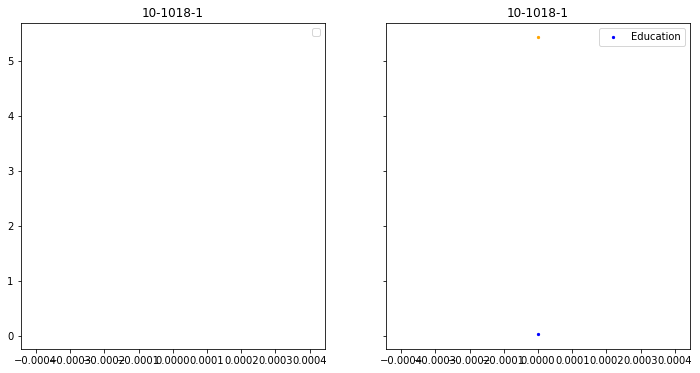

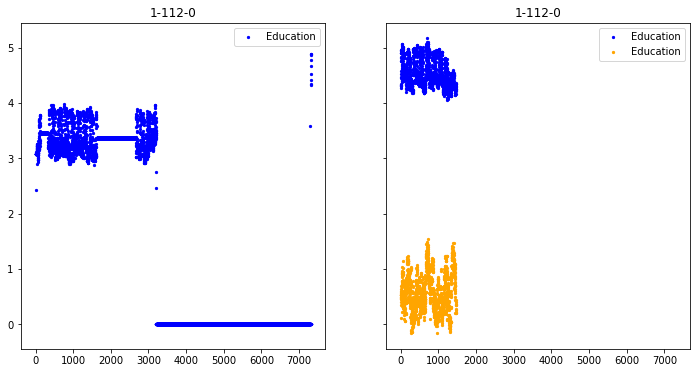

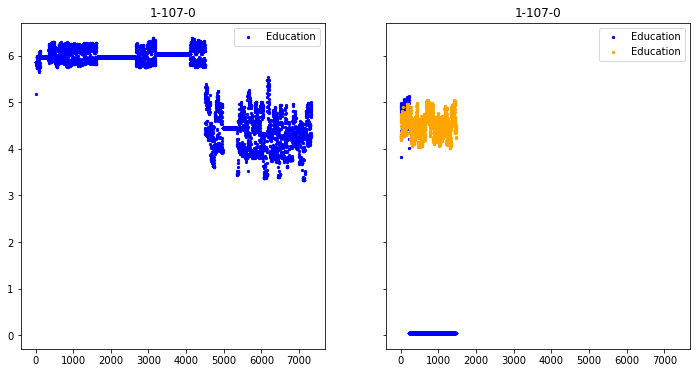

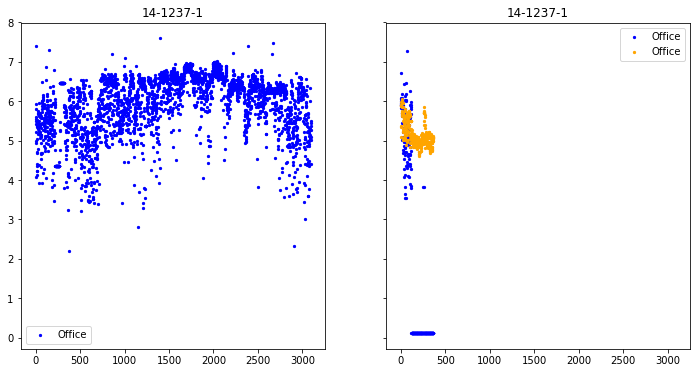

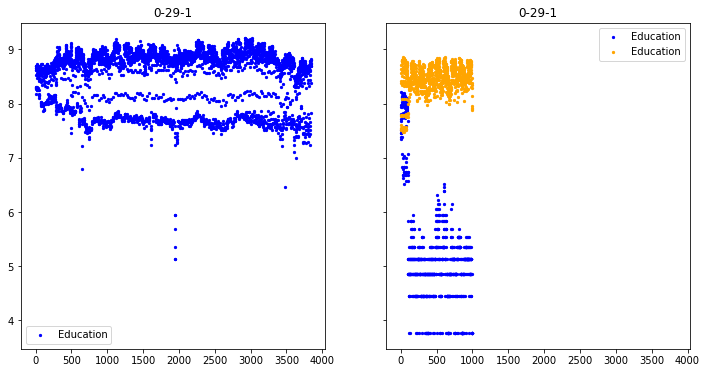

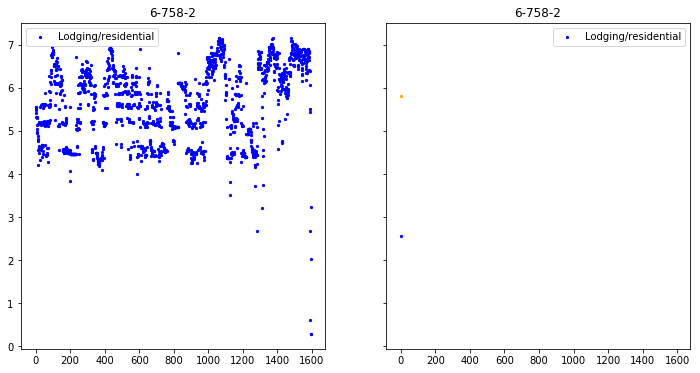

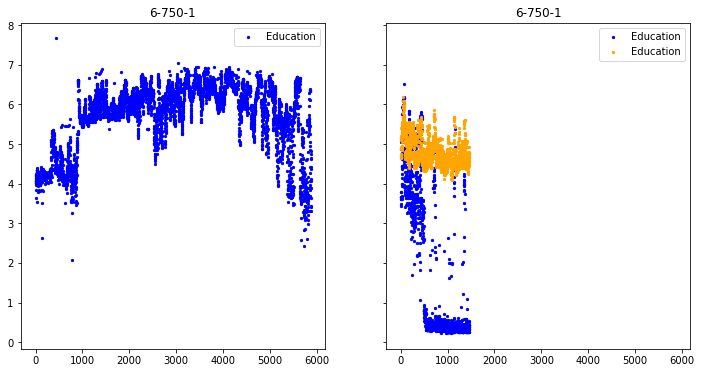

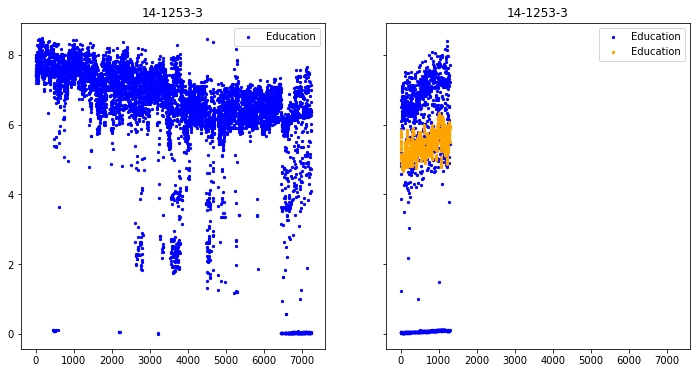

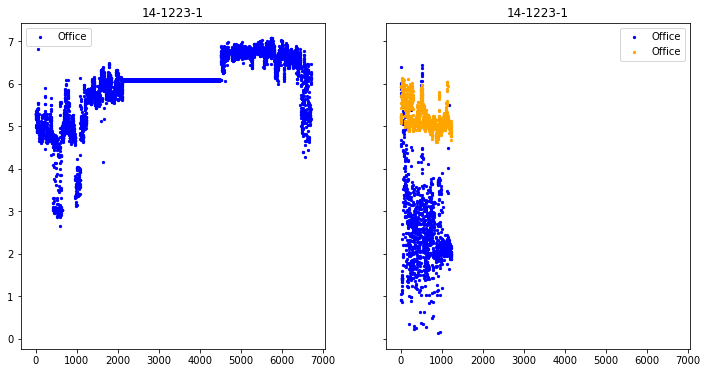

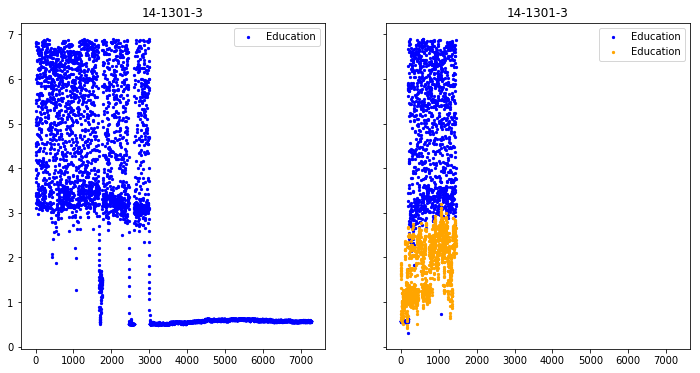

In [27]:
# lets viualize what is going on wrong with these buildings in train and test set both

#Train set
for row in lgbmr_errors.sort_values(by='error', ascending=False).head(10).index:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
    data = df_train.copy()
    data['meter_reading'] = y_train
    data = data.loc[(data['site_id'] == lgbmr_errors.loc[row, 'site_id']) & (data['building_id'] == lgbmr_errors.loc[row, 'building_id']) & (data['meter'] == lgbmr_errors.loc[row, 'meter']), :].reset_index(drop=True)
    ax1.scatter(data.index ,data['meter_reading'], c='blue', s=5)
    ax1.set_title(f"{lgbmr_errors.loc[row, 'site_id']}-{lgbmr_errors.loc[row, 'building_id']}-{lgbmr_errors.loc[row, 'meter']}")
    ax1.legend(data['primary_use'])
    data = viz_data.loc[(viz_data['site_id'] == lgbmr_errors.loc[row, 'site_id']) & (viz_data['building_id'] == lgbmr_errors.loc[row, 'building_id']) & (viz_data['meter'] == lgbmr_errors.loc[row, 'meter']), :].reset_index(drop=True)
    ax2.scatter(data.index ,data['meter_reading'], c='blue', s=5)
    ax2.scatter(data.index ,data['predictions'], c='orange', s=5)
    ax2.set_title(f"{lgbmr_errors.loc[row, 'site_id']}-{lgbmr_errors.loc[row, 'building_id']}-{lgbmr_errors.loc[row, 'meter']}")
    ax2.legend(data['primary_use'])
    plt.show()

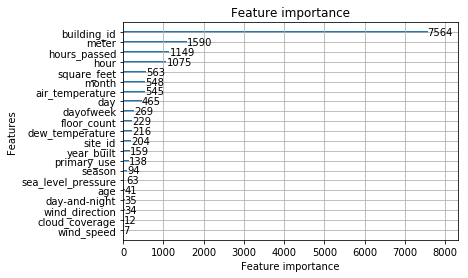

In [28]:
plot_importance(lgbmr)

In [29]:
# #Val set
# fig, ax = plt.subplots(figsize=(12,9))
# data = viz_data.loc[(viz_data['site_id'] == 7) & (viz_data['building_id'] == 799) & (viz_data['meter'] == 0), :].reset_index(drop=True)
# ax.scatter(data.index ,data['meter_reading'], c='blue', s=5)
# ax.scatter(data.index ,data['predictions'], c='orange', s=5)
# ax.legend(data['primary_use'])

## Ensemble Modelling

In [30]:
# Half and half learning
X_1st_half = df_train[:int(df_train.shape[0]/2)]
y_1st_half = y_train[:int(df_train.shape[0]/2)]
X_2nd_half = df_train[int(df_train.shape[0]/2):]
y_2nd_half = y_train[int(df_train.shape[0]/2):]

In [31]:
lgbmr_1st_half = LGBMRegressor(random_state=10)
lgbmr_2nd_half = LGBMRegressor(random_state=10)
lgbmr_1st_half.fit(X_1st_half, y_1st_half)
lgbmr_2nd_half.fit(X_2nd_half, y_2nd_half)
y_predict_1 = lgbmr_1st_half.predict(df_val)
y_predict_2 = lgbmr_2nd_half.predict(df_val)
y_predict_1_2 = (pd.Series(data=y_predict_1, name='prediction_1') + pd.Series(data=y_predict_2, name='prediction_2'))/2
score = np.sqrt(mse(y_val, y_predict_1_2))
print(f"score: {score}")

score: 0.6872332459182277


In [32]:
# Training model on entire dataset using Half and half learning methodology
X_1st_half = df_train[:int(pd.concat([df_train, df_val], axis=0).shape[0]/2)]
y_1st_half = y_train[:int(pd.concat([df_train, df_val], axis=0).shape[0]/2)]
X_2nd_half = df_train[int(pd.concat([df_train, df_val], axis=0).shape[0]/2):]
y_2nd_half = y_train[int(pd.concat([df_train, df_val], axis=0).shape[0]/2):]

lgbmr_1st_half = LGBMRegressor(random_state=10)
lgbmr_2nd_half = LGBMRegressor(random_state=10)
lgbmr_1st_half.fit(X_1st_half, y_1st_half)
lgbmr_2nd_half.fit(X_2nd_half, y_2nd_half)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=10, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
# Saving model
filename = 'lgbm_model1.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

filename = 'lgbmr_1st_half.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
lgbmr_1st_half = pickle.load(open(filename, 'rb'))
filename = 'lgbmr_2nd_half.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
lgbmr_2nd_half = pickle.load(open(filename, 'rb'))

In [34]:
# # Important features
# fig, ax = plt.subplots(figsize=(12, 9))
# plot_importance(lgbmr, ax=ax)

In [35]:
# fig, ax = plt.subplots(figsize=(12, 9))
# plot_importance(lgbmr_1st_half, ax=ax)

In [36]:
# fig, ax = plt.subplots(figsize=(12, 9))
# plot_importance(lgbmr_2nd_half, ax=ax)

In [37]:
del df_train, df_val, y_train, y_val, lgbmr
gc.collect()

65

In [38]:
# Make predictions on test set
# STEP = 1000000
# y_test_predict = []
# for i in range(0, df_test.shape[0], STEP):
#     batch_prediction = loaded_model.predict(df_test.loc[i:i+STEP-1,:])
#     y_test_predict.append(list(batch_prediction))
# y_test = []
# for predictions in y_test_predict:
#     y_test = y_test + predictions

STEP = 1000000
y_test_predict = []
for i in range(0, df_test.shape[0], STEP):
    batch_prediction = lgbmr_1st_half.predict(df_test.loc[i:i+STEP-1,:])
    y_test_predict.append(list(batch_prediction))
y_test_1st_half = []
for predictions in y_test_predict:
    y_test_1st_half = y_test_1st_half + predictions
    
STEP = 1000000
y_test_predict = []
for i in range(0, df_test.shape[0], STEP):
    batch_prediction = lgbmr_2nd_half.predict(df_test.loc[i:i+STEP-1,:])
    y_test_predict.append(list(batch_prediction))
y_test_2nd_half = []
for predictions in y_test_predict:
    y_test_2nd_half = y_test_2nd_half + predictions


In [39]:
# sample['meter_reading'] = y_test
sample['meter_reading'] = (pd.Series(data=y_test_1st_half, name='pred_1st_half') + 
                           pd.Series(data=y_test_2nd_half, name='pred_2nd_half'))/2 

In [40]:
from math import e
# sample['meter_reading'] = e**sample['meter_reading'] - 1
sample['meter_reading'] = np.expm1(sample['meter_reading'])

In [41]:
sample.to_csv("submission.csv", index=False, float_format='%.4f')

References:
* https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction
* https://www.kaggle.com/rohanrao/ashrae-half-and-half